# Attention Model
## Author: Gary Corcoran
## Date: Jan. 19th, 2017

Attention Label Classiftion of Dashcam videos.

### Dataset Class

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

(100, 3, 224, 224) 4
(100, 3, 224, 224) 4
(100, 3, 224, 224) 3
(100, 3, 224, 224) 4
(100, 3, 224, 224) 2


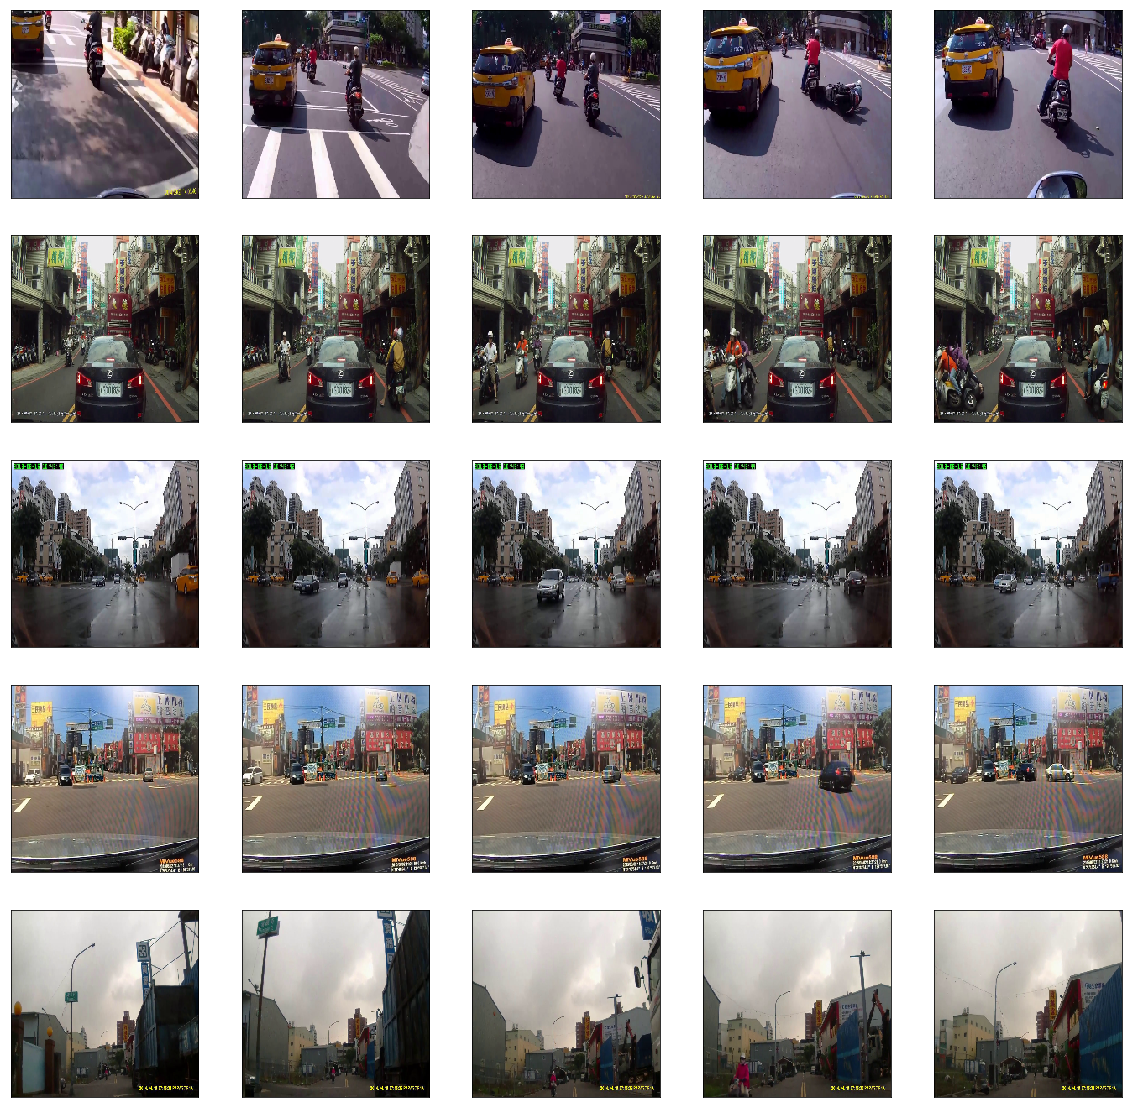

In [2]:
class AttentionDataset(Dataset):
    """
    Attention Level Dataset.
    """
    def __init__(self, labels_path):
        """
        @param labels_path: path to text file with annotations
                                @pre string
        """
        # read video paths and labels
        with open(labels_path) as file:
            data = file.read()
            data = data.split()
            data = np.array(data)
            data = np.reshape(data, (-1, 2))
        self.data = data
        np.random.shuffle(self.data)
        self.cap = cv2.VideoCapture()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # ndarray to store frames
        X = np.zeros((100, 3, 224, 224), dtype=np.float32)
        y = int(self.data[idx, 1]) - 1
        video_path = self.data[idx, 0]
        self.cap.open(video_path)
        for i in range(100):
            ret, frame = self.cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, (224,224))
            frame = np.transpose(frame, (2,0,1))
            X[i] = frame
            
        sample = {'X': X, 'y': y}
        # release video capture device
        self.cap.release()
        return sample
    

# load the dataset
labels_path = '/home/gary/datasets/accv/labels_gary.txt'
attention_dataset = AttentionDataset(labels_path)

def imshow(image):
    # reshape into Height x Width x Channels
    image = np.transpose(image, (1,2,0))
    # convert to RGB
    image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    
    
# display sampled version of dataset
plt.figure(figsize=(20,20))
for i in range(len(attention_dataset)):
    sample = attention_dataset[i]
    print(sample['X'].shape, sample['y']+1)
    plt.subplot(5, 5, i*5+1), imshow(sample['X'][19])
    plt.subplot(5, 5, i*5+2), imshow(sample['X'][39])
    plt.subplot(5, 5, i*5+3), imshow(sample['X'][59])
    plt.subplot(5, 5, i*5+4), imshow(sample['X'][79])
    plt.subplot(5, 5, i*5+5), imshow(sample['X'][99])
    
    if i == 4:
        plt.show()
        break     

### DataLoaders

In [ ]:
# split dataset into training and validation
num_instances = len(attention_dataset)
indices = list(range(num_instances))
np.random.shuffle(indices)
split = int(np.floor(num_instances * 0.8))

train_idx, valid_idx = indices[:split][:10], indices[split:][:10]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create data loaders for training and validation
dataloaders = {'Train': DataLoader(attention_dataset, batch_size=10, 
                             sampler=train_sampler, num_workers=4),
              'Valid': DataLoader(attention_dataset, batch_size=10,
                         sampler=valid_sampler, num_workers=4)}

dataset_sizes = {'Train': len(train_idx), 'Valid': len(valid_idx)}
print(dataset_sizes)

In [ ]:
class CRNN(nn.Module):
    """LeNet5 + Recurrent Neural Network."""
    def __init__(self, input_size, rnn_hidden, num_classes, batch_size):
        super().__init__()
        self.rnn_hidden = rnn_hidden
        self.batch_size = batch_size
        self.n = int((((input_size[1]-4)/2)-4)/2)
        self.conv1 = nn.Conv2d(input_size[0], 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*self.n*self.n, 120)
        self.fc2 = nn.Linear(120, 84)
        self.rnn = nn.RNN(self.fc2.out_features, rnn_hidden, 1)
        self.linear = nn.Linear(rnn_hidden, num_classes)
        
    def init_hidden(self):
        hidden = torch.zeros(1, self.batch_size, self.rnn_hidden)
        return hidden
        
    def forward(self, x, hidden):
        # pass through CNN
        feats = F.max_pool2d(F.relu(self.conv1(x)), 2)
        feats = F.max_pool2d(F.relu(self.conv2(feats)), 2)
        feats = feats.view(-1, 16 * self.n * self.n)
        feats = F.relu(self.fc1(feats))
        feats = self.fc2(feats)
        # reformat [1 x batchSize x numFeats]
        feats = feats.unsqueeze(0)
        # pass through RNN
        outputs, hidden = self.rnn(feats, hidden)
        outputs = self.linear(outputs)
        return outputs, hidden
    

# create network
net = CRNN(input_size=(3,224,224), rnn_hidden=32, num_classes=4, batch_size=10)
print(net)

In [ ]:
def train(network, dataloaders, GPU, num_epochs, criterion, optimizer):
    """
    Train Network.
    """
    if GPU:
        network = network.cuda()
        
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        
        # each epoch has a training and validation phase
        for phase in ['Train']:
            if phase == 'Train':
                network.train(True)  # training mode
            else:
                network.train(False)  # evaluation mode
            
            for i_batch, data in enumerate(dataloaders[phase]):
                # get the inputs and labels
                inputs, targets = data['X'], data['y']
                # reshape inputs [numSeqs x numBatch x numChannels x Height x Width]
                inputs = inputs.transpose(0, 1)
                # store in variables
                if GPU:
                    inputs = Variable(inputs.cuda())
                    targets = Variable(targets.cuda())
                    hidden = Variable(network.init_hidden().cuda())
                else:
                    inputs = Variable(inputs)
                    targets = Variable(targets)
                    hidden = Variable(network.init_hidden())
                
                # zero-out gradients
                network.zero_grad()
                
                # for each input in sequence
                for inp in inputs:
                    print('inp:', inp.size())
                    # forward pass
                    outputs, hidden = network.forward(inp, hidden)
                
                print('outputs:', outputs.data[0])
                
    


GPU = True
num_epochs = 1
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

train(net, dataloaders, GPU, num_epochs, criterion, optimizer)

# Appendix

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

class AttentionDataset(Dataset):
    """
    Attention Level Dataset.
    """
    def __init__(self, labels_path, transform=None):
        """
        @param labels_path: path to text file with annotations
                                @pre string
        @transform: optional tranform to be applied on a sample
                                @pre callable
        """
        # read video paths and labels
        with open(labels_path) as file:
            data = file.read()
            data = data.split()
            data = np.array(data)
            data = np.reshape(data, (-1, 2))
        self.data = data
        self.cap = cv2.VideoCapture()
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # list to store frames
        X = []
        y = int(self.data[idx, 1]) - 1
        video_path = self.data[idx, 0]
        # open video
        self.cap.open(video_path)
        while self.cap.isOpened():
            ret, frame = self.cap.read()
            if not ret:
                break
            if self.transform:
                frame = self.transform(frame)
            
            X.append(frame)
            
        sample = {'X': X, 'y': y}
        # release video capture device
        self.cap.release()
        return sample
    

data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

# load the dataset
attention_dataset = AttentionDataset(labels_path='../labels_gary.txt', 
                                     transform=data_transforms)

In [ ]:
def imshow(img):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std* img + mean
    img = np.clip(img, 0, 1)
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    
# display sampled version of dataset
plt.figure(figsize=(20,20))
for i in range(len(attention_dataset)):
    sample = attention_dataset[i]
    print('ex:', i, 'num_seqs:', len(sample['X']), 'frame_shape:',
          sample['X'][0].shape, 'label:', sample['y'])
    
    plt.subplot(5, 5, i*5+1), imshow(sample['X'][19])
    plt.xticks([]), plt.yticks([])
    plt.subplot(5, 5, i*5+2), imshow(sample['X'][39])
    plt.xticks([]), plt.yticks([])
    plt.subplot(5, 5, i*5+3), imshow(sample['X'][59])
    plt.xticks([]), plt.yticks([])
    plt.subplot(5, 5, i*5+4), imshow(sample['X'][79])
    plt.xticks([]), plt.yticks([])
    plt.subplot(5, 5, i*5+5), imshow(sample['X'][99])
    plt.xticks([]), plt.yticks([])
    
    if i == 4:
        plt.show()
        break     

### Dataset Loader

In [ ]:
# split dataset into training and validation
num_instances = len(attention_dataset)
indices = list(range(num_instances))
np.random.shuffle(indices)
split = int(np.floor(num_instances * 0.8))

train_idx, valid_idx = indices[:split][:10], indices[split:][:10]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create data loaders for training and validation
dataloaders = {'Train': DataLoader(attention_dataset, batch_size=10, 
                             sampler=train_sampler, num_workers=4),
              'Valid': DataLoader(attention_dataset, batch_size=10,
                         sampler=valid_sampler, num_workers=4)}

dataset_sizes = {'Train': len(train_idx), 'Valid': len(valid_idx)}
print(dataset_sizes)

### ResNet as Feature Extractor into Linear Classifier

In [ ]:
import torch.nn as nn
from torchvision import models

GPU = True

# load a pretrained model and reset final fully connected layer
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

if GPU:
    model = model.cuda()

print(model)

In [ ]:
import time
import torch
import torch.optim as optim
from torch.autograd import Variable

num_epochs = 1
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), learning_rate)
best_acc = 0.0

# start timer
start = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    # each epoch has a training and validation phase
    for phase in ['Train', 'Valid']:
        if phase == 'Train':
            model.train(True)  # training mode
        else:
            model.train(False)  # evaluation mode
            
        running_loss = 0.0
        running_correct = 0

        # iterate over data
        for i_batch, data in enumerate(dataloaders[phase]):       
            # get the inputs and labels
            inputs, targets = data['X'], data['y']
            
            # store in variables
            if GPU:
                inputs, targets = Variable(inputs.cuda()), Variable(targets. cuda())
            else:
                inputs, targets = Variable(inputs), Variable(targets)

            # zero-out gradient
            model.zero_grad()
            
            # forward
            print(inputs.size())
            outputs = model(inputs)
            print(outputs.size())
            
            # compute loss
            loss = criterion(outputs, targets)
            running_loss += loss.data[0]
            
            # backward + optimize only if in training phase
            if phase == 'Train':
                loss.backward()
                optimizer.step() 
            
            # compute accuracy
            _, y_pred = torch.max(outputs.data, 1)
            correct = (y_pred == targets.data).sum()
            running_correct += correct
    
        # statistics
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_correct / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        
        if phase == 'Valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
    
    print()

time_elapsed = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best Validation Acc: {:4f}'.format(best_acc))

### ResNet Feature Extractor with RNN

In [ ]:
class RNN(nn.Module):
    """
    Recurrent Neural Network.
    
    @param input_size: number of input neurons
    @param hidden_size: number of hidden neurons
    @param output_size: number of output neurons
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, data, hidden):
        combined = torch.cat((data, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size, GPU):
        if GPU:
            return Variable(torch.zeros(batch_size, self.hidden_size).cuda())
        return Variable(torch.zeros(batch_size, self.hidden_size))


GPU = True

# load a pretrained model and reset final fully connected layer
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.RNN(num_ftrs, 16, 1, batch_first)

if GPU:
    model = model.cuda()

print(model)

In [ ]:
import time
import torch
import torch.optim as optim
from torch.autograd import Variable

num_epochs = 1
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), learning_rate)
best_acc = 0.0

# start timer
start = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    # each epoch has a training and validation phase
    for phase in ['Train', 'Valid']:
        if phase == 'Train':
            model.train(True)  # training mode
        else:
            model.train(False)  # evaluation mode
            
        running_loss = 0.0
        running_correct = 0

        # iterate over data
        for i_batch, data in enumerate(dataloaders[phase]):
            # zero-out gradient
            model.zero_grad()    
            # initialize hidden
            hidden = model.fc.init_hidden(10, GPU)
            
            # extract each time sequence
            for seq in data['X']:
                # get the inputs and labels
                inputs, targets = seq, data['y']
            
                # store in variables
                if GPU:
                    inputs, targets = Variable(inputs.cuda()), Variable(targets. cuda())
                else:
                    inputs, targets = Variable(inputs), Variable(targets)


            
                # forward
                output, hidden = model(inputs, hidden)
            
            # compute loss
            loss = criterion(outputs, targets)
            running_loss += loss.data[0]
            
            # backward + optimize only if in training phase
            if phase == 'Train':
                loss.backward()
                optimizer.step() 
            
            # compute accuracy
            _, y_pred = torch.max(outputs.data, 1)
            correct = (y_pred == targets.data).sum()
            running_correct += correct
    
        # statistics
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_correct / dataset_sizes[phase]
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        
        if phase == 'Valid' and epoch_acc > best_acc:
            best_acc = epoch_acc
    
    print()

time_elapsed = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best Validation Acc: {:4f}'.format(best_acc))